## Dependencies

In [1]:
%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

C:\Users\Abhijit\Documents\GitHub\cpsc490\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
dataset = Planetoid(root='../data/Cora', name='Cora')

data = dataset[0]

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:data.num_nodes - 1000] = 1

data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask[data.num_nodes - 1000:data.num_nodes - 500] = 1

data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[data.num_nodes - 500:] = 1

## Model

In [3]:
class Net(torch.nn.Module):
    def __init__(self, num_features, dim=16, num_classes=1):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, dim)
        self.conv2 = GCNConv(dim, num_classes)

    def forward(self, x, edge_index, data=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## Training

In [4]:
epochs = 200
dim = 16

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=dataset.num_features, dim=dim, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

In [6]:
def test(model, data):
    model.eval()
    logits, accs = model(data.x, data.edge_index, data), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [7]:
train_acc, val_acc, test_acc = 0, 0, 0
data = data.to(device)

for epoch in range(epochs):
    model.train()
    loss = 0
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index, data)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # validate
    train_acc, val_acc, test_acc = test(model, data)
    train_loss = loss
    
    print('Train_loss:{:.6f} Train_acc: {:.4f}, Val_acc: {:.4f}, Test_acc: {:.4f}'.format(loss, train_acc, val_acc, test_acc))

Train_loss:1.955572 Train_acc: 0.4690, Val_acc: 0.3840, Test_acc: 0.4840
Train_loss:1.874908 Train_acc: 0.5334, Val_acc: 0.4360, Test_acc: 0.5660
Train_loss:1.801370 Train_acc: 0.5281, Val_acc: 0.4260, Test_acc: 0.5620
Train_loss:1.738049 Train_acc: 0.5521, Val_acc: 0.4540, Test_acc: 0.6020
Train_loss:1.673522 Train_acc: 0.5984, Val_acc: 0.4960, Test_acc: 0.6500
Train_loss:1.607644 Train_acc: 0.6347, Val_acc: 0.5420, Test_acc: 0.6840
Train_loss:1.519692 Train_acc: 0.6622, Val_acc: 0.5860, Test_acc: 0.7040
Train_loss:1.454443 Train_acc: 0.6950, Val_acc: 0.6140, Test_acc: 0.7200
Train_loss:1.404381 Train_acc: 0.7102, Val_acc: 0.6300, Test_acc: 0.7320
Train_loss:1.342562 Train_acc: 0.7336, Val_acc: 0.6580, Test_acc: 0.7640
Train_loss:1.275741 Train_acc: 0.7553, Val_acc: 0.6760, Test_acc: 0.7820
Train_loss:1.227578 Train_acc: 0.7734, Val_acc: 0.7080, Test_acc: 0.7960
Train_loss:1.167901 Train_acc: 0.7957, Val_acc: 0.7260, Test_acc: 0.8120
Train_loss:1.104239 Train_acc: 0.8220, Val_acc: 0.7

Train_loss:0.350979 Train_acc: 0.9485, Val_acc: 0.8680, Test_acc: 0.8900
Train_loss:0.329207 Train_acc: 0.9473, Val_acc: 0.8660, Test_acc: 0.8860
Train_loss:0.347557 Train_acc: 0.9467, Val_acc: 0.8680, Test_acc: 0.8860
Train_loss:0.333093 Train_acc: 0.9450, Val_acc: 0.8700, Test_acc: 0.8880
Train_loss:0.330934 Train_acc: 0.9450, Val_acc: 0.8660, Test_acc: 0.8860
Train_loss:0.339023 Train_acc: 0.9461, Val_acc: 0.8680, Test_acc: 0.8900
Train_loss:0.333291 Train_acc: 0.9450, Val_acc: 0.8700, Test_acc: 0.8920
Train_loss:0.336527 Train_acc: 0.9473, Val_acc: 0.8700, Test_acc: 0.8900
Train_loss:0.343019 Train_acc: 0.9473, Val_acc: 0.8700, Test_acc: 0.8920
Train_loss:0.339212 Train_acc: 0.9467, Val_acc: 0.8700, Test_acc: 0.8900
Train_loss:0.338340 Train_acc: 0.9456, Val_acc: 0.8720, Test_acc: 0.8900
Train_loss:0.346624 Train_acc: 0.9461, Val_acc: 0.8600, Test_acc: 0.8920
Train_loss:0.340141 Train_acc: 0.9473, Val_acc: 0.8620, Test_acc: 0.8940
Train_loss:0.330432 Train_acc: 0.9461, Val_acc: 0.8

## GNNExplainer

In [8]:
node_idx = 1542
x, edge_index = data.x, data.edge_index
explainer = GNNExplainer(model, epochs=200)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

Explain node 1542: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.45it/s]


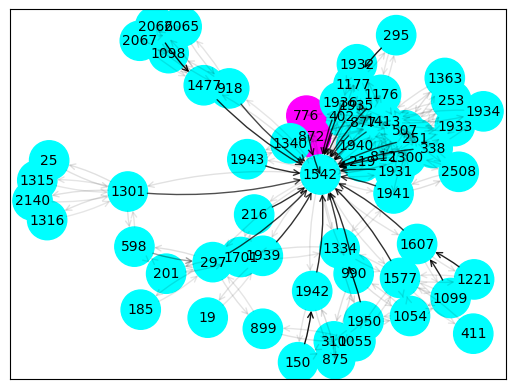

In [9]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

In [10]:
edge_mask_1 = edge_mask

In [11]:
node_idx = 1301
x, edge_index = data.x, data.edge_index
explainer = GNNExplainer(model, epochs=200)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

Explain node 1301: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 181.06it/s]


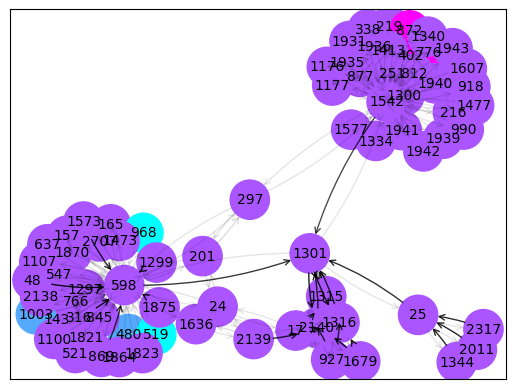

In [12]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

In [13]:
edge_mask_2 = edge_mask

In [14]:
edge_mask_1[edge_mask_1 > 0]

tensor([0.0855, 0.1217, 0.1127, 0.9217, 0.0811, 0.1089, 0.1102, 0.1165, 0.8084,
        0.1005, 0.1182, 0.1172, 0.8254, 0.1017, 0.1071, 0.1082, 0.1060, 0.1147,
        0.7287, 0.1049, 0.0915, 0.1055, 0.1070, 0.0782, 0.9174, 0.1193, 0.1093,
        0.1262, 0.1156, 0.7575, 0.1323, 0.1229, 0.1195, 0.0951, 0.1307, 0.7875,
        0.1067, 0.1261, 0.1371, 0.1197, 0.7787, 0.1284, 0.1185, 0.1336, 0.1186,
        0.1191, 0.1005, 0.1188, 0.1238, 0.0932, 0.0999, 0.1027, 0.1019, 0.0966,
        0.1022, 0.1176, 0.1009, 0.1199, 0.1086, 0.1097, 0.1138, 0.3763, 0.0788,
        0.0912, 0.1073, 0.8166, 0.0840, 0.1050, 0.0899, 0.1126, 0.7876, 0.1053,
        0.1251, 0.8000, 0.1374, 0.1510, 0.1214, 0.0797, 0.5837, 0.1002, 0.1118,
        0.7233, 0.0741, 0.0933, 0.1201, 0.1222, 0.7166, 0.1067, 0.1243, 0.1207,
        0.8214, 0.1233, 0.1180, 0.1039, 0.1149, 0.1040, 0.0950, 0.0902, 0.1294,
        0.0968, 0.1289, 0.1233, 0.0811, 0.8716, 0.1078, 0.1226, 0.1057, 0.7954,
        0.0909, 0.1108, 0.0979, 0.8298, 

In [15]:
torch.sigmoid(torch.logit(edge_mask_1[edge_mask_1 > 0]))

tensor([0.0855, 0.1217, 0.1127, 0.9217, 0.0811, 0.1089, 0.1102, 0.1165, 0.8084,
        0.1005, 0.1182, 0.1172, 0.8254, 0.1017, 0.1071, 0.1082, 0.1060, 0.1147,
        0.7287, 0.1049, 0.0915, 0.1055, 0.1070, 0.0782, 0.9174, 0.1193, 0.1093,
        0.1262, 0.1156, 0.7575, 0.1323, 0.1229, 0.1195, 0.0951, 0.1307, 0.7875,
        0.1067, 0.1261, 0.1371, 0.1197, 0.7787, 0.1284, 0.1185, 0.1336, 0.1186,
        0.1191, 0.1005, 0.1188, 0.1238, 0.0932, 0.0999, 0.1027, 0.1019, 0.0966,
        0.1022, 0.1176, 0.1009, 0.1199, 0.1086, 0.1097, 0.1138, 0.3763, 0.0788,
        0.0912, 0.1073, 0.8166, 0.0840, 0.1050, 0.0899, 0.1126, 0.7876, 0.1053,
        0.1251, 0.8000, 0.1374, 0.1510, 0.1214, 0.0797, 0.5837, 0.1002, 0.1118,
        0.7233, 0.0741, 0.0933, 0.1201, 0.1222, 0.7166, 0.1067, 0.1243, 0.1207,
        0.8214, 0.1233, 0.1180, 0.1039, 0.1149, 0.1040, 0.0950, 0.0902, 0.1294,
        0.0968, 0.1289, 0.1233, 0.0811, 0.8716, 0.1078, 0.1226, 0.1057, 0.7954,
        0.0909, 0.1108, 0.0979, 0.8298, 

In [16]:
new_edge_mask = torch.sigmoid(torch.logit(edge_mask_1) + torch.logit(edge_mask_2))

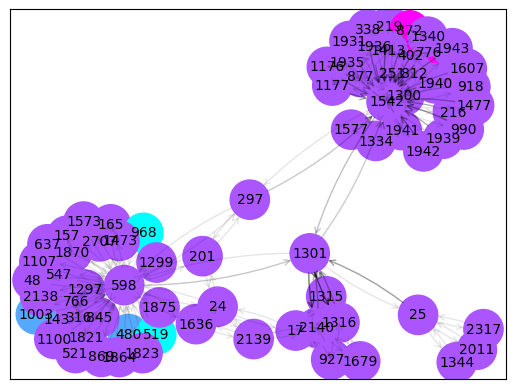

In [17]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, new_edge_mask, y=data.y)
plt.show()

## Modified GNNExplainer

In [18]:
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.nn.models.explainer import clear_masks, set_masks

EPS = 1e-15


class EdgeGNNExplainer(GNNExplainer):
    def _loss(self, log_logits, prediction, node_idx = None):
        print(log_logits.shape, log_logits)
        print(prediction.shape, prediction)
        print(node_idx.shape, node_idx)
        if self.return_type == 'regression':
            if node_idx is not None and (node_idx >= 0).max():
                loss = torch.cdist(log_logits[node_idx], prediction[node_idx])
            else:
                loss = torch.cdist(log_logits, prediction)
        else:
            if node_idx is not None and (node_idx >= 0).max():
                loss = -log_logits[node_idx, prediction[node_idx]]
            else:
                loss = -log_logits[0, prediction[0]]

        if self.allow_edge_mask:
            m = self.edge_mask.sigmoid()
            edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
            loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
            ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
            loss = loss + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_feat_mask.sigmoid()
        node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
        loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss
    
    def edge_subgraph(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)
        subset, edge_index, mapping, edge_mask = k_hop_subgraph(
            node_idx_1, self.num_hops + 1, edge_index, relabel_nodes=True,
            num_nodes=num_nodes, flow=self._flow())
        
        mapping_2 = (subset == node_idx_2).nonzero()[0].item()
        mapping = torch.tensor([mapping[0], mapping_2])
        
        x = x[subset]
        kwargs_new = {}
        for key, value in kwargs.items():
            if torch.is_tensor(value) and value.size(0) == num_nodes:
                kwargs_new[key] = value[subset]
            elif torch.is_tensor(value) and value.size(0) == num_edges:
                kwargs_new[key] = value[edge_mask]
            else:
                kwargs_new[key] = value  # TODO: this is not in PGExplainer
        return x, edge_index, mapping, edge_mask, subset, kwargs_new
    
    
    def explain_edge(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        self.model.eval()
        self._clear_masks()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, subset, kwargs = \
            self.edge_subgraph(node_idx_1, node_idx_2, x, edge_index, **kwargs)

        # Get the initial prediction.
        prediction = self.get_initial_prediction(x, edge_index, **kwargs)

        self._initialize_masks(x, edge_index)
        self.to(x.device)

        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index, apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        # if self.log:  # pragma: no cover
        #     pbar = tqdm(total=self.epochs)
        #     pbar.set_description(f'Explain edge {node_idx_1, node_idx_2}')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.sigmoid()
            out = self.model(x=h, edge_index=edge_index, **kwargs)
            loss = self.get_loss(out, prediction, mapping).sum()
            loss.backward()
            optimizer.step()

            # if self.log:  # pragma: no cover
            #     pbar.update(1)

        # if self.log:  # pragma: no cover
        #     pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x.new_zeros(num_nodes, x.size(-1))
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x.new_zeros(num_nodes, 1)
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()

        if self.allow_edge_mask:
            edge_mask = self.edge_mask.new_zeros(num_edges)
            edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()
        else:
            edge_mask = torch.zeros(num_edges)
            edge_mask[hard_edge_mask] = 1

        self._clear_masks()

        return node_feat_mask, edge_mask

In [19]:
node_idx_1, node_idx_2 = 1542, 1301
x, edge_index = data.x, data.edge_index
edge_explainer = EdgeGNNExplainer(model, epochs=200)
node_feat_mask, edge_mask = edge_explainer.explain_edge(node_idx_1, node_idx_2, x, edge_index)

torch.Size([187, 7]) tensor([[-2.3755, -2.6793, -2.6171,  ..., -1.9322, -2.6197, -2.9064],
        [-2.5176, -2.8553, -2.7956,  ..., -2.3333, -2.5409, -3.1213],
        [-2.6013, -2.6730, -2.7832,  ..., -1.9797, -2.3264, -3.0213],
        ...,
        [-2.2381, -2.5215, -2.6676,  ..., -2.1288, -2.2890, -2.7006],
        [-2.9126, -2.8819, -2.9618,  ..., -3.3090, -2.7769, -3.7533],
        [-2.4499, -2.7519, -2.7917,  ..., -2.3836, -2.6257, -3.0591]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([187]) tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3

torch.Size([187, 7]) tensor([[-2.3769, -2.7075, -2.6305,  ..., -1.9626, -2.6093, -2.9253],
        [-2.5177, -2.8163, -2.7891,  ..., -2.3387, -2.5069, -3.0793],
        [-2.5882, -2.6665, -2.7674,  ..., -2.0431, -2.3089, -3.0022],
        ...,
        [-2.2436, -2.5095, -2.6366,  ..., -2.1455, -2.2674, -2.6824],
        [-3.0348, -2.9671, -2.9910,  ..., -3.2662, -2.8640, -3.8140],
        [-2.4447, -2.7318, -2.7613,  ..., -2.3778, -2.5707, -3.0079]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([187]) tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3

torch.Size([187, 7]) tensor([[-2.3585, -2.7120, -2.6307,  ..., -1.9874, -2.5804, -2.9194],
        [-2.4892, -2.7556, -2.7568,  ..., -2.3195, -2.4401, -3.0007],
        [-2.5446, -2.6466, -2.7289,  ..., -2.0767, -2.2708, -2.9466],
        ...,
        [-2.2285, -2.4834, -2.5943,  ..., -2.1457, -2.2221, -2.6362],
        [-3.0910, -3.0008, -2.9820,  ..., -3.1896, -2.8951, -3.8094],
        [-2.4078, -2.6845, -2.7097,  ..., -2.3469, -2.4858, -2.9220]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([187]) tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3

torch.Size([187, 7]) tensor([[-2.3346, -2.7070, -2.6203,  ..., -2.0011, -2.5457, -2.9024],
        [-2.4409, -2.6836, -2.7040,  ..., -2.2804, -2.3582, -2.9046],
        [-2.4880, -2.6201, -2.6794,  ..., -2.0832, -2.2236, -2.8742],
        ...,
        [-2.2031, -2.4533, -2.5486,  ..., -2.1327, -2.1688, -2.5800],
        [-3.0822, -2.9954, -2.9499,  ..., -3.0967, -2.8698, -3.7463],
        [-2.3584, -2.6268, -2.6493,  ..., -2.3027, -2.3977, -2.8275]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([187]) tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3

torch.Size([187, 7]) tensor([[-2.3121, -2.7001, -2.6079,  ..., -2.0108, -2.5127, -2.8847],
        [-2.3817, -2.6097, -2.6416,  ..., -2.2334, -2.2717, -2.7996],
        [-2.4313, -2.5920, -2.6293,  ..., -2.0789, -2.1764, -2.8004],
        ...,
        [-2.1756, -2.4229, -2.5070,  ..., -2.1176, -2.1166, -2.5246],
        [-3.0391, -2.9623, -2.9152,  ..., -3.0112, -2.8206, -3.6591],
        [-2.3098, -2.5712, -2.5925,  ..., -2.2598, -2.3164, -2.7394]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([187]) tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3

torch.Size([187]) tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
torch.Size([2]) tensor([112,  94])
torch.Size([187, 7]) tensor([[-2.2947, -2.6939, -2.5975,  ..., -2.0200, -2.4866, -2.8704],
        [-2.3270, -2.5450, -2.5845,  ..., -2.1932, -2.1954, -2.7046],
        [-2.3815, -2.5685, -2.5869,  ..., -2.0720, -2.1368, -2.7358],
        ...,
        [-2.1524, -2.3963, -2.4746,  ..., -2.1057, -2.0734, -2.4785],
       

torch.Size([187, 7]) tensor([[-2.2828, -2.6895, -2.5896,  ..., -2.0284, -2.4682, -2.8607],
        [-2.2820, -2.4947, -2.5386,  ..., -2.1625, -2.1345, -2.6271],
        [-2.3421, -2.5501, -2.5534,  ..., -2.0666, -2.1055, -2.6842],
        ...,
        [-2.1351, -2.3762, -2.4512,  ..., -2.0965, -2.0408, -2.4434],
        [-2.9607, -2.8950, -2.8657,  ..., -2.8943, -2.7439, -3.5225],
        [-2.2414, -2.4922, -2.5126,  ..., -2.1992, -2.2026, -2.6148]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([187]) tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3

torch.Size([187, 7]) tensor([[-2.2766, -2.6872, -2.5854,  ..., -2.0337, -2.4585, -2.8557],
        [-2.2549, -2.4653, -2.5113,  ..., -2.1445, -2.0979, -2.5799],
        [-2.3194, -2.5392, -2.5334,  ..., -2.0637, -2.0869, -2.6532],
        ...,
        [-2.1258, -2.3650, -2.4380,  ..., -2.0909, -2.0222, -2.4233],
        [-2.9424, -2.8789, -2.8554,  ..., -2.8659, -2.7270, -3.4894],
        [-2.2253, -2.4729, -2.4933,  ..., -2.1843, -2.1750, -2.5841]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([187]) tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3

torch.Size([187, 7]) tensor([[-2.2719, -2.6854, -2.5822,  ..., -2.0388, -2.4507, -2.8518],
        [-2.2309, -2.4394, -2.4870,  ..., -2.1290, -2.0654, -2.5377],
        [-2.3001, -2.5296, -2.5158,  ..., -2.0618, -2.0703, -2.6259],
        ...,
        [-2.1181, -2.3553, -2.4267,  ..., -2.0861, -2.0062, -2.4059],
        [-2.9276, -2.8656, -2.8481,  ..., -2.8416, -2.7141, -3.4616],
        [-2.2116, -2.4562, -2.4768,  ..., -2.1716, -2.1512, -2.5574]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([187]) tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3

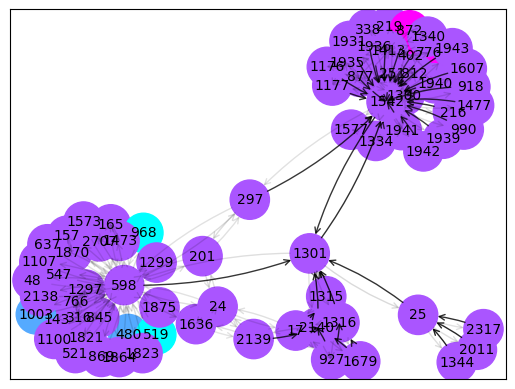

In [20]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()